In [1]:
import pandas as pd
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
import datetime
import re
import seaborn as sns
import re
import glob

In [ ]:
root = pathlib.Path.home()
pt = os.path.join(root, 'research', "gen_287_2013_2017.csv")
data = pd.read_csv(pt)


In [ ]:
data.set_index(pd.DatetimeIndex(data["EventStartDT"]), inplace=True)
data.sort_index(inplace=True)
data.drop(columns=["NetAvailableCapacityMW_grp", "WorkDuration", "ContributionCode", "ContributionCodeDesc", "UnitID", "EventCausesID", "EventID", "CauseCode", "UnitTypeCode", "UnitTypeCodeName"], inplace=True)

In [80]:
birthdate = datetime.datetime(1961, 1, 1)
data["AgeAtEvent"] = np.round((pd.to_datetime(data["EventStartDT"]) - birthdate)/np.timedelta64(1, 'h')).astype(int)

Unit is Sutherland 3 (79.5 MW) in IA, started in 1961, converted to gas in 2011

https://www.oasis.oati.com/woa/docs/MISO/MISOdocs/OASIS_Posting_of_Approved_Generator_Retirements_(Public)_2023-03-30.pdf


https://www.gem.wiki/Sutherland_Generating_Station

In [64]:
data[data["OutageContinuationFlag"] != 0][["Duration", "EventEndDT"]]

,Duration,EventEndDT
EventStartDT,,
2013-01-01 06:00:00,"39 days, 0:01:00",2013-02-09 06:01:00
2013-12-30 23:10:00,"1 day, 6:50:00",2014-01-01 06:00:00
2014-01-01 06:00:00,"31 days, 0:00:00",2014-02-01 06:00:00
2015-12-01 06:00:00,"31 days, 0:00:00",2016-01-01 06:00:00
2016-01-01 06:00:00,"28 days, 4:14:00",2016-01-29 10:14:00
2016-12-01 06:00:00,"31 days, 0:00:00",2017-01-01 06:00:00
2017-01-01 06:00:00,"150 days, 23:00:00",2017-06-01 05:00:00
2017-06-01 05:00:00,"214 days, 1:00:00",2018-01-01 06:00:00


In [73]:
date1 = "2016-12-01 06:00:00"
duration1 = data.at[date1, "Duration"]
matched1 = re.findall(r"(?:(?:(\d+):)?(\d+):)?(\d+(?:\.\d+)?)", duration1)
days = int(matched1[0][2])
hours = int(matched1[1][0])
minutes = int(matched1[1][1])
timedelta1 = datetime.timedelta(days=days, hours=hours, minutes=minutes)


date2 = "2017-01-01 06:00:00"
duration2 = data.at[date2, "Duration"]
matched2 = re.findall(r"(?:(?:(\d+):)?(\d+):)?(\d+(?:\.\d+)?)", duration2)
days = int(matched2[0][2])
hours = int(matched2[1][0])
minutes = int(matched2[1][1])
timedelta2 = datetime.timedelta(days=days, hours=hours, minutes=minutes)

data.at[date1, "Duration"] = timedelta1 + timedelta2
data.at[date1, "EventEndDT"] = data.at[date2, "EventEndDT"]
data.drop(index=date2, inplace=True)

In [74]:
data[data["OutageContinuationFlag"] != 0][["Duration", "EventEndDT"]]

,Duration,EventEndDT
EventStartDT,,
2013-01-01 06:00:00,"39 days, 0:01:00",2013-02-09 06:01:00
2013-12-30 23:10:00,"32 days, 6:50:00",2014-02-01 06:00:00
2015-12-01 06:00:00,"59 days, 4:14:00",2016-01-29 10:14:00
2016-12-01 06:00:00,"181 days, 23:00:00",2017-06-01 05:00:00
2017-06-01 05:00:00,"214 days, 1:00:00",2018-01-01 06:00:00


In [118]:

data["AgeAtEvent"]

EventStartDT
2013-01-01 06:00:00    455838
2013-02-09 06:01:00    456774
2013-03-01 20:30:00    457268
2013-03-28 20:58:00    457917
2013-04-22 01:47:00    458498
                        ...  
2016-09-01 05:00:00    487973
2016-10-01 05:00:00    488693
2016-11-01 05:00:00    489437
2016-12-01 06:00:00    490158
2017-06-01 05:00:00    494525
Name: AgeAtEvent, Length: 89, dtype: int64

In [113]:
mydict = {"RS": 5,
          "PO": 3,
          "U1": 2,
          "SF": 2,
          "MO": 4,
          "PD": 3,
          "A" : 1,
          "F": 2,
          "RU": 6}

start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2018, 1, 2)

date_range = pd.date_range(start=start_date, end=end_date, freq='min')
state = np.ones(len(date_range))
cause = np.full(len(date_range), 1)

datetimes = data.index
indexes = [int(i.total_seconds()/60) for i in datetimes - start_date]

for k in range(len(indexes)):
    start_time = datetimes[k]
    mytime = data.loc[datetimes[k], "Duration"]
    mycause = data.loc[datetimes[k], "EventTypeCode"]
    # myage = data.loc[(datetimes[k], slice(None)), "AgeAtEvent"].values[0]

    if type(mytime) == datetime.time:
        mytime = datetime.datetime.combine(datetime.datetime.min, mytime) - datetime.datetime.min
    elif type(mytime) == str:
        matched2 = re.findall(r"(?:(?:(\d+):)?(\d+):)?(\d+(?:\.\d+)?)", mytime)
        if len(matched2) > 1:
            days = int(matched2[0][2])
            hours = int(matched2[1][0])
            minutes = int(matched2[1][1])
            mytime = datetime.timedelta(days=days, hours=hours, minutes=minutes)
        else:
            hours = int(matched2[0][0])
            minutes = int(matched2[0][1])
            mytime = datetime.timedelta(hours=hours, minutes=minutes)
    end_time = start_time + mytime

    start_index = np.ravel(np.where(date_range == start_time))[0]
    end_index = np.ravel(np.where(date_range == end_time))[0]

    state[start_index:end_index] = 0
    cause[start_index:end_index] = mydict[mycause]


In [121]:
starting_age = 455838
ending_age = int((end_date - birthdate).total_seconds()/(60*60))
age = np.linspace(starting_age, ending_age, len(date_range))

In [124]:
new_dataframe = pd.DataFrame(index=date_range)
new_dataframe["State"] = state
new_dataframe["s_t"] = cause
new_dataframe["age"] = age

In [125]:
new_dataframe["2013-01-01":"2014-01-01 00:00"]

,State,s_t,age
2013-01-01 00:00:00,1.0,1,455838.000000
2013-01-01 00:01:00,1.0,1,455838.016664
2013-01-01 00:02:00,1.0,1,455838.033329
2013-01-01 00:03:00,1.0,1,455838.049993
2013-01-01 00:04:00,1.0,1,455838.066658
...,...,...,...
2013-12-31 23:56:00,0.0,5,464596.734656
2013-12-31 23:57:00,0.0,5,464596.751320
2013-12-31 23:58:00,0.0,5,464596.767985
2013-12-31 23:59:00,0.0,5,464596.784649


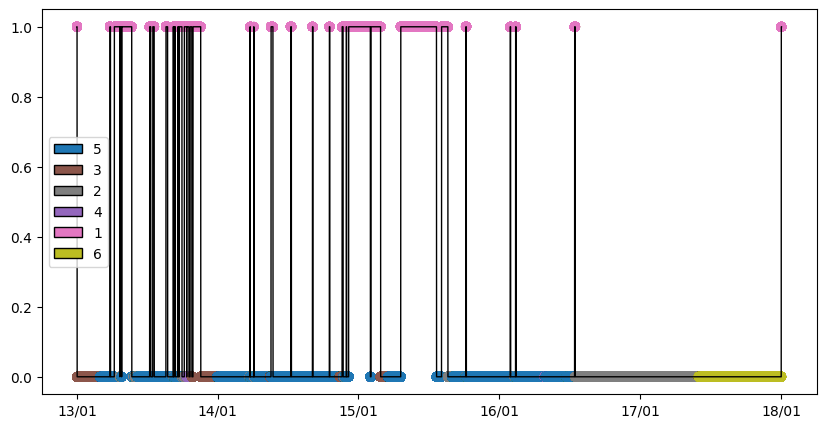

In [129]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(DateFormatter("%y/%m"))

colordict = dict({v:c for v, c in zip(mydict.values(), colors)})

ax.scatter(date_range, state, c=[colordict[i] for i in cause])
ax.plot(date_range, state, lw=1, c='k')

patches = []
for k, v in colordict.items():
    patches.append(mpatches.Patch(color=v, label=k, ec='k'))
ax.legend(handles=patches, loc="center left")

In [127]:
new_dataframe.to_csv('gen_287_2013_2017_state.csv')